# Dependencies

In [1]:
! pip install yfinance
! pip install plotly
! pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 942 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 5.1 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=4388e623e537d90d556190d1ee27bc16b764f1ed7352d3b8e2fd203a39401543
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [2]:
# Raw Packages
import numpy as np
import pandas as pd
import pandas_ta as ta
from functools import reduce

# ML
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

# Data Source
import yfinance as yf

# Data Visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sn
#import shap

## Data Collection

In [3]:
def readCSV(filename, twitter=False):
  df = pd.read_csv(filename, na_values='.')
  if twitter:
    df['Date'] = pd.to_datetime(df['tweet_yyyymmdd'])
    df.set_index('Date', inplace=True)
    return df

  df['Date'] = pd.to_datetime(df['DATE'])
  df.set_index('Date', inplace=True)

  return df

In [4]:
def convert_monthly_to_daily(dataframe):

  start_date = dataframe.index.min() - pd.DateOffset(day=1)
  end_date = dataframe.index.max() + pd.DateOffset(day=31)
  
  dates = pd.date_range(start_date, end_date, freq='D')
  dates.name = 'Date'
  dataframe = dataframe.reindex(dates, method='ffill')

  dataframe.reset_index(inplace=True)
  dataframe.drop('DATE', inplace=True, axis=1)
  #dataframe.set_index('Date', inplace=True)

  return dataframe

In [5]:
def cm_metrics(cm):
    True_Positive = cm[1][1]
    True_Negative = cm[0][0]
    False_Positive = cm[0][1]
    False_Negative = cm[1][0]
    
    # Accuracy
    conf_accuracy = (float (True_Positive+True_Negative) / float(True_Positive + True_Negative + False_Positive + False_Negative))
    
    # Mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # Sensitivity
    conf_sensitivity = (True_Positive / float(True_Positive + False_Negative))

    # Specificity
    conf_specificity = (True_Negative / float(True_Negative + False_Positive))
    
    # Precision
    conf_precision = (True_Negative / float(True_Negative + False_Positive))
    # f-1
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
  
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')


In [6]:
# Daily Macroeconomic Indicators
emu_df = readCSV('WLEMUINDXD.csv')                                     # Equity Market-related Economic Uncertainty Index                        / 2017-07-17 - 2022-07-17
vix_df = readCSV('VIXCLS.csv')                                         # Volatility Index                                                        / 2017-07-17 - 2022-07-15 
epu_df = readCSV('USEPUINDXD.csv')                                     # Economic Policy Uncertainty Index for US                                / 2017-07-17 - 2022-07-17
ir5_df = readCSV('T5YIFR.csv')                                         # 5-Year Forward Inflation Expectation Rate                               / 2017-07-18 - 2022-07-18
ovx_df = readCSV('OVXCLS.csv')                                         # Crude Oil ETF Volatility Index                                          / 2017-07-17 - 2022-07-15
dsg_df = readCSV('DGS10.csv')                                          # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity   / 2017-07-17 - 2022-07-15

# Monthly Macroeconomic Indicators 
tb3_df = convert_monthly_to_daily(readCSV('TB3MS.csv'))                # 3-Month Treasury Bill Secondary Market Rate                             / 1934-01-01 - 2022-06-30
emv_df = convert_monthly_to_daily(readCSV('EMVOVERALLEMV.csv'))        # Equity Market Volatility Tracker                                        / 1985-01-01 - 2022-06-30
icp_df = convert_monthly_to_daily(readCSV('FPCPITOTLZGUSA.csv'))       # Inflation, consumer prices for USA                                      / 1960-01-01 - 2021-01-31

In [7]:
# Twitter Sentiment Analysis Weights
two_cluster_weights = readCSV('two_cluster_weights.csv', True)
three_cluster_weights = readCSV('three_cluster_weights.csv', True)

In [8]:
# *NOTE* (Revisit) Twitter Sentiment Dataset Time Range: 2021-02-05 to 2022-07-09

btc_df = yf.download(tickers='BTC-USD', start="2021-02-05", end="2022-06-30")
gld_df = yf.download(tickers='GC=F', start="2021-02-05", end="2022-06-30")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
print(btc_df.shape)
print(gld_df.shape)

(511, 6)
(353, 6)


In [10]:
# *NOTE* Decide What to do with icp_df because of date range, removing...
#btc_df = [btc_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df, icp_df]
btc_df = [btc_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df, two_cluster_weights]
#btc_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
#                                            how='inner'), btc_df)
btc_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                             how='left'), btc_df)
btc_df_merged.drop('DATE_x', inplace=True, axis=1)
btc_df_merged.drop('DATE_y', inplace=True, axis=1)
#btc_df_merged.drop('tweet_yyyymmdd', inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'DATE_x'} in the result is deprecated and will raise a MergeError in a future version.
  import sys


In [11]:
# Not sure if I can delete
btc_df_merged.reset_index(inplace=True)

In [12]:
# forward fill macroeconomic NaN values 
btc_df_merged.ffill(inplace=True)

In [13]:
# We will remove the first value from the data frame as it cannot forward fill
print(btc_df_merged[btc_df_merged.isnull().any(axis=1)])
btc_df_merged = btc_df_merged.iloc[1: , :]
print(btc_df_merged[btc_df_merged.isnull().any(axis=1)]) # Should be empty

Empty DataFrame
Columns: [index, Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV, tweet_yyyymmdd, sentiment]
Index: []
Empty DataFrame
Columns: [index, Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV, tweet_yyyymmdd, sentiment]
Index: []


In [14]:
gld_df = [gld_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df]
gld_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), gld_df)
gld_df_merged.drop('DATE_x', inplace=True, axis=1)
gld_df_merged.drop('DATE_y', inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'DATE_x'} in the result is deprecated and will raise a MergeError in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Not sure if I can delete
gld_df_merged.reset_index(inplace=True)

In [16]:
# forward fill macroeconomic NaN values 
gld_df_merged.ffill(inplace=True)

In [17]:
# We will remove the first value from the data frame as it cannot forward fill
print(gld_df_merged[gld_df_merged.isnull().any(axis=1)])
gld_df_merged = gld_df_merged.iloc[1: , :]
print(gld_df_merged[gld_df_merged.isnull().any(axis=1)]) # Should be empty

Empty DataFrame
Columns: [index, Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV]
Index: []
Empty DataFrame
Columns: [index, Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV]
Index: []


In [18]:
def rsi(data, periods=14, close_col='Close'):
  data.reset_index(inplace=True)
  data['rsi_u'] = 0.
  data['rsi_d'] = 0.
  data['RSI'] = 0.
  
  for index,row in data.iterrows():
      if index >= periods:
          
          prev_close = data.at[index-periods, close_col]
          if prev_close < row[close_col]:
              data.at[index, 'rsi_u'] = row[close_col] - prev_close
          elif prev_close > row[close_col]:
              data.at[index, 'rsi_d'] = prev_close - row[close_col]
          
  data['RSI'] = data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() / (data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() + data['rsi_d'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean())
  
  data = data.drop(['rsi_u', 'rsi_d'], axis=1)
  data.set_index('Date', inplace=True)
  return data

In [19]:
btc_df_merged = rsi(btc_df_merged)
gld_df_merged = rsi(gld_df_merged)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [20]:
def ema(data, period=0, column='Close'):
  data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
  
  return data

def macd(data, period_long=26, period_short=12, period_signal=9, column='Close'):
  remove_cols = []
  data.reset_index(inplace=True)
  if not 'ema' + str(period_long) in data.columns:
    data = ema(data, period_long)
    remove_cols.append('ema' + str(period_long))

  if not 'ema' + str(period_short) in data.columns:
    data = ema(data, period_short)
    remove_cols.append('ema' + str(period_short))

  data['MACD'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
  data['MACD_Signal_Line'] = data['MACD'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

  data = data.drop(remove_cols, axis=1)
  data.set_index('Date', inplace=True)
      
  return data

In [21]:
btc_df_merged = macd(btc_df_merged)
gld_df_merged = macd(gld_df_merged)

In [22]:
def ADX(df):
  high = df['High']
  low = df['Low']
  close = df['Close']
  lookback = 14
  adx = pd.DataFrame()
  plus_dm = high.diff()
  minus_dm = low.diff()
  plus_dm[plus_dm < 0] = 0
  minus_dm[minus_dm > 0] = 0
  
  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.rolling(lookback).mean()
  
  plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
  minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
  dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
  adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
  adx_smooth = adx.ewm(alpha = 1/lookback).mean()
  return adx_smooth

In [23]:
btc_df_merged['ADX'] = ADX(btc_df_merged)
gld_df_merged['ADX'] = ADX(gld_df_merged)

In [24]:
def stochastic_fast_slow(df):
  low_min = df['Low'].rolling(window=14).min()
  high_max = df['High'].rolling(window=14).max()

  k_fast = 100 * (df['Close'] - low_min)/(high_max - low_min)
  d_fast = k_fast.rolling(window = 3).mean()

  k_slow = d_fast
  d_slow = k_slow.rolling(window = 3).mean()

  return k_fast, d_fast, k_slow, d_slow

In [25]:
btc_df_merged['STOFASTK'] = stochastic_fast_slow(btc_df_merged)[0]
btc_df_merged['STOFASTD'] = stochastic_fast_slow(btc_df_merged)[1]
btc_df_merged['STOSLOWD'] = stochastic_fast_slow(btc_df_merged)[3]

gld_df_merged['STOFASTK'] = stochastic_fast_slow(gld_df_merged)[0]
gld_df_merged['STOFASTD'] = stochastic_fast_slow(gld_df_merged)[1]
gld_df_merged['STOSLOWD'] = stochastic_fast_slow(gld_df_merged)[3]

In [26]:
btc_df_merged['MA50'] = btc_df_merged['Close'].rolling(window=50).mean()
btc_df_merged['MA200'] = btc_df_merged['Close'].rolling(window=200).mean()

gld_df_merged['MA50'] = gld_df_merged['Close'].rolling(window=50).mean()
gld_df_merged['MA200'] = gld_df_merged['Close'].rolling(window=200).mean()

In [27]:
def ROC(data, periods=14, close_col='Close'):
  data.reset_index(inplace=True)
  data['ROC'] = 0.
  
  for index,row in data.iterrows():
    if index >= periods:
      prev_close = data.at[index-periods, close_col]
      val_perc = (row[close_col] - prev_close)/prev_close

      data.at[index, 'ROC'] = val_perc
  data.set_index('Date', inplace=True)
  return data

In [28]:
btc_df_merged = ROC(btc_df_merged)
gld_df_merged = ROC(gld_df_merged)

In [29]:
def OBV(data):
  trend_periods = 21
  close_col = 'Close'
  vol_col = 'Volume'
  data.reset_index(inplace=True)
  for index, row in data.iterrows():
    if index > 0:
      last_obv = data.at[index - 1, 'OBV']
      if row[close_col] > data.at[index - 1, close_col]:
        current_obv = last_obv + row[vol_col]
      elif row[close_col] < data.at[index - 1, close_col]:
        current_obv = last_obv - row[vol_col]
      else:
        current_obv = last_obv
    else:
      last_obv = 0
      current_obv = row[vol_col]

    data.at[index, 'OBV'] = current_obv

  data.set_index('Date', inplace=True)
  return data

In [30]:
btc_df_merged = OBV(btc_df_merged)

gld_df_merged = OBV(gld_df_merged)

In [31]:
def typical_price(data, high_col = 'High', low_col = 'Low', close_col = 'Close'):
  data['typical_price'] = (data[high_col] + data[low_col] + data[close_col]) / 3

  return data

def MFI(data, periods=14, vol_col='Volume'):
  data.reset_index(inplace=True)
  remove_tp_col = False
  if not 'typical_price' in data.columns:
    data = typical_price(data)
    remove_tp_col = True
  
  data['money_flow'] = data['typical_price'] * data[vol_col]
  data['money_ratio'] = 0.
  data['MFI'] = 0.
  data['money_flow_positive'] = 0.
  data['money_flow_negative'] = 0.
  
  for index,row in data.iterrows():
    if index > 0:
      if row['typical_price'] < data.at[index-1, 'typical_price']:
          data.at[index, 'money_flow_positive'] = row['money_flow']
      else:
          data.at[index, 'money_flow_negative'] = row['money_flow']

    if index >= periods:
      period_slice = data['money_flow'][index-periods:index]
      positive_sum = data['money_flow_positive'][index-periods:index].sum()
      negative_sum = data['money_flow_negative'][index-periods:index].sum()

      if negative_sum == 0.:
        #this is to avoid division by zero below
        negative_sum = 0.00001
      m_r = positive_sum / negative_sum

      mfi = 1-(1 / (1 + m_r))

      data.at[index, 'money_ratio'] = m_r
      data.at[index, 'MFI'] = mfi
        
  data = data.drop(['money_flow', 'money_ratio', 'money_flow_positive', 'money_flow_negative'], axis=1)

  if remove_tp_col:
    data = data.drop(['typical_price'], axis=1)
  data.set_index('Date', inplace=True)

  return data

In [32]:
btc_df_merged = MFI(btc_df_merged)

gld_df_merged = MFI(gld_df_merged)

In [33]:
def WAD(data, high_col='High', low_col='Low', close_col='Close'):
  data.reset_index(inplace=True)
  data['WAD'] = 0.
  
  for index,row in data.iterrows():
    if index > 0:
      prev_value = data.at[index-1, 'WAD']
      prev_close = data.at[index-1, close_col]
      if row[close_col] > prev_close:
        ad = row[close_col] - min(prev_close, row[low_col])
      elif row[close_col] < prev_close:
        ad = row[close_col] - max(prev_close, row[high_col])
      else:
        ad = 0.
                                                                                                  
      data.at[index,'WAD'] = ad+prev_value
  data.set_index('Date', inplace=True) 
  return data

In [34]:
btc_df_merged = WAD(btc_df_merged)

gld_df_merged = WAD(gld_df_merged)

In [35]:
print(len(btc_df_merged.columns))
btc_df_merged.columns

31


Index(['level_0', 'index', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS',
       'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'tweet_yyyymmdd', 'sentiment', 'RSI',
       'MACD', 'MACD_Signal_Line', 'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD',
       'MA50', 'MA200', 'ROC', 'OBV', 'MFI', 'WAD'],
      dtype='object')

In [36]:
print(len(gld_df_merged.columns))
gld_df_merged.columns

29


Index(['level_0', 'index', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS',
       'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line',
       'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC',
       'OBV', 'MFI', 'WAD'],
      dtype='object')

# EDA & Feature Engineering


In [37]:
#def normalization function to clean data
def normalize(df):
    for column in df:
        df[column]=((df[column]-df[column].mean())/df[column].std())

In [38]:
btc_df_merged['Class_5'] = (btc_df_merged['Close'].shift(periods = -5,fill_value = 0) - btc_df_merged['Close'])
gld_df_merged['Class_5'] = (gld_df_merged['Close'].shift(periods = -5,fill_value = 0) - gld_df_merged['Close'])

btc_df_merged['Class_10'] = (btc_df_merged['Close'].shift(periods = -10,fill_value = 0) - btc_df_merged['Close'])
gld_df_merged['Class_10'] = (gld_df_merged['Close'].shift(periods = -10,fill_value = 0) - gld_df_merged['Close'])

btc_df_merged['Class_15'] = (btc_df_merged['Close'].shift(periods = -15,fill_value = 0) - btc_df_merged['Close'])
gld_df_merged['Class_15'] = (gld_df_merged['Close'].shift(periods = -15,fill_value = 0) - gld_df_merged['Close'])

btc_df_merged['Class_20'] = (btc_df_merged['Close'].shift(periods = -20,fill_value = 0) - btc_df_merged['Close'])
gld_df_merged['Class_20'] = (gld_df_merged['Close'].shift(periods = -20,fill_value = 0) - gld_df_merged['Close'])

In [39]:
btc_df_merged['Class_5'] = (btc_df_merged['Class_5'] > 0)
gld_df_merged['Class_5'] = (gld_df_merged['Class_5'] > 0)

btc_df_merged['Class_10'] = (btc_df_merged['Class_10'] > 0)
gld_df_merged['Class_10'] = (gld_df_merged['Class_10'] > 0)

btc_df_merged['Class_15'] = (btc_df_merged['Class_15'] > 0)
gld_df_merged['Class_15'] = (gld_df_merged['Class_15'] > 0)

btc_df_merged['Class_20'] = (btc_df_merged['Class_20'] > 0)
gld_df_merged['Class_20'] = (gld_df_merged['Class_20'] > 0)

In [40]:
classify_btc_5 = btc_df_merged['Class_5']
classify_gld_5 = gld_df_merged['Class_5']

classify_btc_10 = btc_df_merged['Class_10']
classify_gld_10 = gld_df_merged['Class_10']

classify_btc_15 = btc_df_merged['Class_15']
classify_gld_15 = gld_df_merged['Class_15']

classify_btc_20 = btc_df_merged['Class_20']
classify_gld_20 = gld_df_merged['Class_20']

In [41]:
# Drop unnecessary columns
btc_df_merged.reset_index(inplace=True)
btc_df_merged.drop('level_0', inplace=True, axis=1)
btc_df_merged.drop('index', inplace=True, axis=1)
btc_df_merged.drop('tweet_yyyymmdd', inplace=True, axis=1)

btc_df_merged.drop('Open', inplace=True, axis=1)
btc_df_merged.drop('Close', inplace=True, axis=1)

btc_df_merged.drop('High', inplace=True, axis=1)
btc_df_merged.drop('Low', inplace=True, axis=1)
btc_df_merged.drop('Adj Close', inplace=True, axis=1)
btc_df_merged.drop('Volume', inplace=True, axis=1)
btc_df_merged.drop('Date', inplace=True, axis=1)
btc_df_merged.drop('Class_5', inplace=True, axis=1)
btc_df_merged.drop('Class_10', inplace=True, axis=1)
btc_df_merged.drop('Class_15', inplace=True, axis=1)
btc_df_merged.drop('Class_20', inplace=True, axis=1)

#btc_df_merged = btc_df_merged.drop(btc_df_merged.index[-1])

btc_df_merged.tail()

,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,sentiment,RSI,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
505,276.95,27.23,248.22,2.30,46.99,3.13,1.49,17.72192,0.223870,0.029717,...,41.891262,36.521228,33.932069,29.859640,27418.594023,38514.644092,-0.214304,-6.465533e+11,0.687821,1722.802734
506,80.69,26.95,141.39,2.31,46.99,3.20,1.49,17.72192,0.223870,0.029139,...,41.886277,56.999406,42.888982,35.852892,27152.118281,38379.960879,-0.077906,-6.675190e+11,0.671178,980.191406
507,73.18,28.36,130.09,2.23,46.59,3.20,1.49,17.72192,0.400261,0.028487,...,42.062200,49.842302,47.787645,41.536232,26951.791914,38245.147529,-0.086737,-6.889005e+11,0.628568,96.402344
508,53.62,28.16,136.16,2.13,48.57,3.10,1.49,17.72192,0.416646,0.027637,...,42.398307,46.419800,51.087169,47.254599,26733.414258,38098.855107,-0.109371,-7.124533e+11,0.598554,-163.730469
509,175.03,28.71,154.39,2.08,48.90,2.98,1.49,17.72192,0.416646,0.027425,...,42.866069,50.946056,49.069386,49.314733,26550.381680,37947.287061,-0.029287,-7.387205e+11,0.561050,-520.164062


In [42]:
# Drop unnecessary columns
gld_df_merged.reset_index(inplace=True)
gld_df_merged.drop('index', inplace=True, axis=1)
gld_df_merged.drop('level_0', inplace=True, axis=1)

gld_df_merged.drop('Open', inplace=True, axis=1)
gld_df_merged.drop('Close', inplace=True, axis=1)

gld_df_merged.drop('High', inplace=True, axis=1)
gld_df_merged.drop('Low', inplace=True, axis=1)
gld_df_merged.drop('Adj Close', inplace=True, axis=1)
gld_df_merged.drop('Volume', inplace=True, axis=1)
gld_df_merged.drop('Date', inplace=True, axis=1)
gld_df_merged.drop('Class_5', inplace=True, axis=1)
gld_df_merged.drop('Class_10', inplace=True, axis=1)
gld_df_merged.drop('Class_15', inplace=True, axis=1)
gld_df_merged.drop('Class_20', inplace=True, axis=1)

gld_df_merged.tail()

,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,RSI,MACD,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
347,54.99,29.05,97.75,2.31,48.58,3.09,1.49,17.72192,0.243733,-16.444488,...,7.601821,29.018383,37.316221,42.247466,1867.536003,1841.722495,-0.021859,-401376.0,0.257574,206.598999
348,84.03,27.23,116.03,2.30,46.99,3.13,1.49,17.72192,0.233845,-16.514197,...,7.291479,30.156434,33.475546,37.600725,1864.624004,1841.867994,-0.010242,-401315.0,0.289799,217.298950
349,80.69,26.95,141.39,2.31,46.99,3.20,1.49,17.72192,0.224400,-16.752472,...,7.026406,22.190600,27.121806,32.637858,1861.422004,1842.024495,-0.009950,-401392.0,0.290869,207.499023
350,73.18,28.36,130.09,2.23,46.59,3.20,1.49,17.72192,0.209536,-17.052157,...,6.582033,17.354145,23.233726,27.943693,1858.354004,1842.151995,-0.016238,-401783.0,0.264087,198.999023
351,53.62,28.16,136.16,2.13,48.57,3.10,1.49,17.72192,0.192169,-17.421532,...,6.290023,11.948664,17.164470,22.506667,1854.970002,1842.196995,-0.020628,-401956.0,0.419846,182.398926


In [43]:
print(len(btc_df_merged.columns))
btc_df_merged.columns

22


Index(['WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS', 'DGS10',
       'TB3MS', 'EMVOVERALLEMV', 'sentiment', 'RSI', 'MACD',
       'MACD_Signal_Line', 'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50',
       'MA200', 'ROC', 'OBV', 'MFI', 'WAD'],
      dtype='object')

In [44]:
print(len(gld_df_merged.columns))
gld_df_merged.columns

21


Index(['WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS', 'DGS10',
       'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line', 'ADX',
       'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC', 'OBV',
       'MFI', 'WAD'],
      dtype='object')

In [45]:
print(btc_df_merged.isna().sum())

WLEMUINDXD            0
VIXCLS                0
USEPUINDXD            0
T5YIFR                0
OVXCLS                0
DGS10                 0
TB3MS                 0
EMVOVERALLEMV         0
sentiment             0
RSI                  14
MACD                 25
MACD_Signal_Line     25
ADX                  14
STOFASTK             13
STOFASTD             15
STOSLOWD             17
MA50                 49
MA200               199
ROC                   0
OBV                   0
MFI                   0
WAD                   0
dtype: int64


In [46]:
print(gld_df_merged.isna().sum())

WLEMUINDXD            0
VIXCLS                0
USEPUINDXD            0
T5YIFR                0
OVXCLS                0
DGS10                 0
TB3MS                 0
EMVOVERALLEMV         0
RSI                  14
MACD                 25
MACD_Signal_Line     25
ADX                  14
STOFASTK             13
STOFASTD             15
STOSLOWD             17
MA50                 49
MA200               199
ROC                   0
OBV                   0
MFI                   0
WAD                   0
dtype: int64


In [47]:
btc_df_merged.fillna(btc_df_merged.mean(), inplace=True)

In [48]:
print(btc_df_merged.isna().sum())

WLEMUINDXD          0
VIXCLS              0
USEPUINDXD          0
T5YIFR              0
OVXCLS              0
DGS10               0
TB3MS               0
EMVOVERALLEMV       0
sentiment           0
RSI                 0
MACD                0
MACD_Signal_Line    0
ADX                 0
STOFASTK            0
STOFASTD            0
STOSLOWD            0
MA50                0
MA200               0
ROC                 0
OBV                 0
MFI                 0
WAD                 0
dtype: int64


In [49]:
gld_df_merged.fillna(gld_df_merged.mean(), inplace=True)

In [50]:
print(gld_df_merged.isna().sum())

WLEMUINDXD          0
VIXCLS              0
USEPUINDXD          0
T5YIFR              0
OVXCLS              0
DGS10               0
TB3MS               0
EMVOVERALLEMV       0
RSI                 0
MACD                0
MACD_Signal_Line    0
ADX                 0
STOFASTK            0
STOFASTD            0
STOSLOWD            0
MA50                0
MA200               0
ROC                 0
OBV                 0
MFI                 0
WAD                 0
dtype: int64


In [51]:
# remove last 15 rows, because of the 15 day period classification
btc_df_merged_5 = btc_df_merged[:-5]
classify_btc_5 = classify_btc_5[:-5]

btc_df_merged_10 = btc_df_merged[:-10]
classify_btc_10 = classify_btc_10[:-10]

btc_df_merged_15 = btc_df_merged[:-15]
classify_btc_15 = classify_btc_15[:-15]

btc_df_merged_20 = btc_df_merged[:-20]
classify_btc_20 = classify_btc_20[:-20]

In [52]:
# remove last 15 rows, because of the 15 day period classification 
gld_df_merged_5 = gld_df_merged[:-5]
classify_gld_5 = classify_gld_5[:-5]

gld_df_merged_10 = gld_df_merged[:-10]
classify_gld_10 = classify_gld_10[:-10]

gld_df_merged_15 = gld_df_merged[:-15]
classify_gld_15 = classify_gld_15[:-15]

gld_df_merged_20 = gld_df_merged[:-20]
classify_gld_20 = classify_gld_20[:-20]

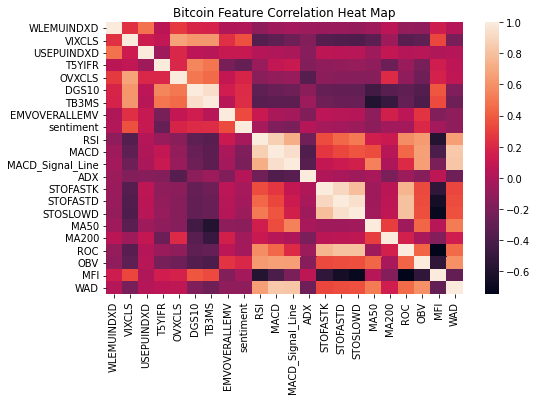

In [53]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title("Bitcoin Feature Correlation Heat Map")
corrMatrix = btc_df_merged.corr()
sn.heatmap(corrMatrix)
plt.show()

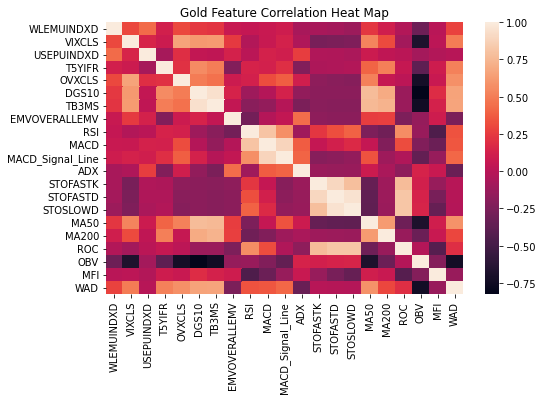

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title("Gold Feature Correlation Heat Map")
corrMatrix = gld_df_merged.corr()
sn.heatmap(corrMatrix)
plt.show()

# ML Models


In [55]:
model_results_btc = {
  'RandomForestClassifier' : [],
  'GradientBoostingClassifier' : [],
  'BaggingClassifier' : [],
  'LogisticRegression' : [],
  'VotingClassifier' : []
}
model_results_gld = {
  'RandomForestClassifier' : [],
  'GradientBoostingClassifier' : [],
  'BaggingClassifier' : [],
  'LogisticRegression' : [],
  'VotingClassifier' : []
}

## Random Forest Classifier
Normalization is not needed for RF, refer here for more information: https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf

In [56]:
RF_btc_df_merged_5_accuracies = []
RF_btc_df_merged_10_accuracies = []
RF_btc_df_merged_15_accuracies = []
RF_btc_df_merged_20_accuracies = []

for i in range (0,4):
  X_btc_5 = btc_df_merged_5
  Y_btc_5 = classify_btc_5
  X_btc_train_5, X_btc_test_5, Y_btc_train_5, Y_btc_test_5 = train_test_split(X_btc_5, Y_btc_5, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_btc_train_5, Y_btc_train_5)
  #y_train_pred = model.predict(X_btc_train_5)
  #y_test_pred = model.predict(X_btc_test_5)
  RF_btc_df_merged_5_accuracies.append(model.score(X_btc_test_5, Y_btc_test_5))

for i in range (0,4):
  X_btc_10 = btc_df_merged_10
  Y_btc_10 = classify_btc_10
  X_btc_train_10, X_btc_test_10, Y_btc_train_10, Y_btc_test_10 = train_test_split(X_btc_10, Y_btc_10, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_btc_train_10, Y_btc_train_10)
  #y_train_pred = model.predict(X_btc_train_10)
  #y_test_pred = model.predict(X_btc_test_10)
  RF_btc_df_merged_10_accuracies.append(model.score(X_btc_test_10, Y_btc_test_10))

for i in range (0,4):
  X_btc_15 = btc_df_merged_15
  Y_btc_15 = classify_btc_15
  X_btc_train_15, X_btc_test_15, Y_btc_train_15, Y_btc_test_15 = train_test_split(X_btc_15, Y_btc_15, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_btc_train_15, Y_btc_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  RF_btc_df_merged_15_accuracies.append(model.score(X_btc_test_15, Y_btc_test_15))

for i in range (0,4):
  X_btc_20 = btc_df_merged_20
  Y_btc_20 = classify_btc_20
  X_btc_train_20, X_btc_test_20, Y_btc_train_20, Y_btc_test_20 = train_test_split(X_btc_20, Y_btc_20, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_btc_train_20, Y_btc_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  RF_btc_df_merged_20_accuracies.append(model.score(X_btc_test_20, Y_btc_test_20))

In [57]:
RF_gld_df_merged_5_accuracies = []
RF_gld_df_merged_10_accuracies = []
RF_gld_df_merged_15_accuracies = []
RF_gld_df_merged_20_accuracies = []

for i in range (0,4):
  X_gld_5 = gld_df_merged_5
  Y_gld_5 = classify_gld_5
  X_gld_train_5, X_gld_test_5, Y_gld_train_5, Y_gld_test_5 = train_test_split(X_gld_5, Y_gld_5, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_gld_train_5, Y_gld_train_5)
  #y_train_pred = model.predict(X_gld_train_5)
  #y_test_pred = model.predict(X_gld_test_5)
  RF_gld_df_merged_5_accuracies.append(model.score(X_gld_test_5, Y_gld_test_5))

for i in range (0,4):
  X_gld_10 = gld_df_merged_10
  Y_gld_10 = classify_gld_10
  X_gld_train_10, X_gld_test_10, Y_gld_train_10, Y_gld_test_10 = train_test_split(X_gld_10, Y_gld_10, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_gld_train_10, Y_gld_train_10)
  #y_train_pred = model.predict(X_gld_train_10)
  #y_test_pred = model.predict(X_gld_test_10)
  RF_gld_df_merged_10_accuracies.append(model.score(X_gld_test_10, Y_gld_test_10))

for i in range (0,4):
  X_gld_15 = gld_df_merged_15
  Y_gld_15 = classify_gld_15
  X_gld_train_15, X_gld_test_15, Y_gld_train_15, Y_gld_test_15 = train_test_split(X_gld_15, Y_gld_15, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_gld_train_15, Y_gld_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  RF_gld_df_merged_15_accuracies.append(model.score(X_gld_test_15, Y_gld_test_15))

for i in range (0,4):
  X_gld_20 = gld_df_merged_20
  Y_gld_20 = classify_gld_20
  X_gld_train_20, X_gld_test_20, Y_gld_train_20, Y_gld_test_20 = train_test_split(X_gld_20, Y_gld_20, test_size=0.3)
  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_gld_train_20, Y_gld_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  RF_gld_df_merged_20_accuracies.append(model.score(X_gld_test_20, Y_gld_test_20))

In [58]:
def Average(lst):
    return sum(lst) / len(lst)

In [59]:
average_btc_5_RF = Average(RF_btc_df_merged_5_accuracies)
average_btc_10_RF = Average(RF_btc_df_merged_10_accuracies)
average_btc_15_RF = Average(RF_btc_df_merged_15_accuracies)
average_btc_20_RF = Average(RF_btc_df_merged_20_accuracies)

average_gld_5_RF = Average(RF_gld_df_merged_5_accuracies)
average_gld_10_RF = Average(RF_gld_df_merged_10_accuracies)
average_gld_15_RF = Average(RF_gld_df_merged_15_accuracies)
average_gld_20_RF = Average(RF_gld_df_merged_20_accuracies)

In [60]:
model_results_btc['RandomForestClassifier'].append(average_btc_5_RF)
model_results_btc['RandomForestClassifier'].append(average_btc_10_RF)
model_results_btc['RandomForestClassifier'].append(average_btc_15_RF)
model_results_btc['RandomForestClassifier'].append(average_btc_20_RF)

model_results_gld['RandomForestClassifier'].append(average_gld_5_RF)
model_results_gld['RandomForestClassifier'].append(average_gld_10_RF)
model_results_gld['RandomForestClassifier'].append(average_gld_15_RF)
model_results_gld['RandomForestClassifier'].append(average_gld_20_RF)

# Gradient Boosting Classifier

In [61]:
GB_btc_df_merged_5_accuracies = []
GB_btc_df_merged_10_accuracies = []
GB_btc_df_merged_15_accuracies = []
GB_btc_df_merged_20_accuracies = []

for i in range (0,4):
  X_btc_5 = btc_df_merged_5
  Y_btc_5 = classify_btc_5
  X_btc_train_5, X_btc_test_5, Y_btc_train_5, Y_btc_test_5 = train_test_split(X_btc_5, Y_btc_5, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_btc_train_5, Y_btc_train_5)
  #y_train_pred = model.predict(X_btc_train_5)
  #y_test_pred = model.predict(X_btc_test_5)
  GB_btc_df_merged_5_accuracies.append(model.score(X_btc_test_5, Y_btc_test_5))

for i in range (0,4):
  X_btc_10 = btc_df_merged_10
  Y_btc_10 = classify_btc_10
  X_btc_train_10, X_btc_test_10, Y_btc_train_10, Y_btc_test_10 = train_test_split(X_btc_10, Y_btc_10, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_btc_train_10, Y_btc_train_10)
  #y_train_pred = model.predict(X_btc_train_10)
  #y_test_pred = model.predict(X_btc_test_10)
  GB_btc_df_merged_10_accuracies.append(model.score(X_btc_test_10, Y_btc_test_10))

for i in range (0,4):
  X_btc_15 = btc_df_merged_15
  Y_btc_15 = classify_btc_15
  X_btc_train_15, X_btc_test_15, Y_btc_train_15, Y_btc_test_15 = train_test_split(X_btc_15, Y_btc_15, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_btc_train_15, Y_btc_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  GB_btc_df_merged_15_accuracies.append(model.score(X_btc_test_15, Y_btc_test_15))

for i in range (0,4):
  X_btc_20 = btc_df_merged_20
  Y_btc_20 = classify_btc_20
  X_btc_train_20, X_btc_test_20, Y_btc_train_20, Y_btc_test_20 = train_test_split(X_btc_20, Y_btc_20, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_btc_train_20, Y_btc_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  GB_btc_df_merged_20_accuracies.append(model.score(X_btc_test_20, Y_btc_test_20))

In [62]:
GB_gld_df_merged_5_accuracies = []
GB_gld_df_merged_10_accuracies = []
GB_gld_df_merged_15_accuracies = []
GB_gld_df_merged_20_accuracies = []

for i in range (0,4):
  X_gld_5 = gld_df_merged_5
  Y_gld_5 = classify_gld_5
  X_gld_train_5, X_gld_test_5, Y_gld_train_5, Y_gld_test_5 = train_test_split(X_gld_5, Y_gld_5, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_gld_train_5, Y_gld_train_5)
  #y_train_pred = model.predict(X_gld_train_5)
  #y_test_pred = model.predict(X_gld_test_5)
  GB_gld_df_merged_5_accuracies.append(model.score(X_gld_test_5, Y_gld_test_5))

for i in range (0,4):
  X_gld_10 = gld_df_merged_10
  Y_gld_10 = classify_gld_10
  X_gld_train_10, X_gld_test_10, Y_gld_train_10, Y_gld_test_10 = train_test_split(X_gld_10, Y_gld_10, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_gld_train_10, Y_gld_train_10)
  #y_train_pred = model.predict(X_gld_train_10)
  #y_test_pred = model.predict(X_gld_test_10)
  GB_gld_df_merged_10_accuracies.append(model.score(X_gld_test_10, Y_gld_test_10))

for i in range (0,4):
  X_gld_15 = gld_df_merged_15
  Y_gld_15 = classify_gld_15
  X_gld_train_15, X_gld_test_15, Y_gld_train_15, Y_gld_test_15 = train_test_split(X_gld_15, Y_gld_15, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_gld_train_15, Y_gld_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  GB_gld_df_merged_15_accuracies.append(model.score(X_gld_test_15, Y_gld_test_15))

for i in range (0,4):
  X_gld_20 = gld_df_merged_20
  Y_gld_20 = classify_gld_20
  X_gld_train_20, X_gld_test_20, Y_gld_train_20, Y_gld_test_20 = train_test_split(X_gld_20, Y_gld_20, test_size=0.3)
  model = GradientBoostingClassifier()
  model.fit(X_gld_train_20, Y_gld_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  GB_gld_df_merged_20_accuracies.append(model.score(X_gld_test_20, Y_gld_test_20))

In [63]:
average_btc_5_GB = Average(GB_btc_df_merged_5_accuracies)
average_btc_10_GB = Average(GB_btc_df_merged_10_accuracies)
average_btc_15_GB = Average(GB_btc_df_merged_15_accuracies)
average_btc_20_GB = Average(GB_btc_df_merged_20_accuracies)

average_gld_5_GB = Average(GB_gld_df_merged_5_accuracies)
average_gld_10_GB = Average(GB_gld_df_merged_10_accuracies)
average_gld_15_GB = Average(GB_gld_df_merged_15_accuracies)
average_gld_20_GB = Average(GB_gld_df_merged_20_accuracies)

In [64]:
model_results_btc['GradientBoostingClassifier'].append(average_btc_5_GB)
model_results_btc['GradientBoostingClassifier'].append(average_btc_10_GB)
model_results_btc['GradientBoostingClassifier'].append(average_btc_15_GB)
model_results_btc['GradientBoostingClassifier'].append(average_btc_20_GB)

model_results_gld['GradientBoostingClassifier'].append(average_gld_5_GB)
model_results_gld['GradientBoostingClassifier'].append(average_gld_10_GB)
model_results_gld['GradientBoostingClassifier'].append(average_gld_15_GB)
model_results_gld['GradientBoostingClassifier'].append(average_gld_20_GB)

## Bagging Classifier

In [65]:
BC_btc_df_merged_5_accuracies = []
BC_btc_df_merged_10_accuracies = []
BC_btc_df_merged_15_accuracies = []
BC_btc_df_merged_20_accuracies = []

for i in range (0,4):
  X_btc_5 = btc_df_merged_5
  Y_btc_5 = classify_btc_5
  X_btc_train_5, X_btc_test_5, Y_btc_train_5, Y_btc_test_5 = train_test_split(X_btc_5, Y_btc_5, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_btc_train_5, Y_btc_train_5)
  #y_train_pred = model.predict(X_btc_train_5)
  #y_test_pred = model.predict(X_btc_test_5)
  BC_btc_df_merged_5_accuracies.append(model.score(X_btc_test_5, Y_btc_test_5))

for i in range (0,4):
  X_btc_10 = btc_df_merged_10
  Y_btc_10 = classify_btc_10
  X_btc_train_10, X_btc_test_10, Y_btc_train_10, Y_btc_test_10 = train_test_split(X_btc_10, Y_btc_10, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_btc_train_10, Y_btc_train_10)
  #y_train_pred = model.predict(X_btc_train_10)
  #y_test_pred = model.predict(X_btc_test_10)
  BC_btc_df_merged_10_accuracies.append(model.score(X_btc_test_10, Y_btc_test_10))

for i in range (0,4):
  X_btc_15 = btc_df_merged_15
  Y_btc_15 = classify_btc_15
  X_btc_train_15, X_btc_test_15, Y_btc_train_15, Y_btc_test_15 = train_test_split(X_btc_15, Y_btc_15, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_btc_train_15, Y_btc_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  BC_btc_df_merged_15_accuracies.append(model.score(X_btc_test_15, Y_btc_test_15))

for i in range (0,4):
  X_btc_20 = btc_df_merged_20
  Y_btc_20 = classify_btc_20
  X_btc_train_20, X_btc_test_20, Y_btc_train_20, Y_btc_test_20 = train_test_split(X_btc_20, Y_btc_20, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_btc_train_20, Y_btc_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  BC_btc_df_merged_20_accuracies.append(model.score(X_btc_test_20, Y_btc_test_20))

In [66]:
BC_gld_df_merged_5_accuracies = []
BC_gld_df_merged_10_accuracies = []
BC_gld_df_merged_15_accuracies = []
BC_gld_df_merged_20_accuracies = []

for i in range (0,4):
  X_gld_5 = gld_df_merged_5
  Y_gld_5 = classify_gld_5
  X_gld_train_5, X_gld_test_5, Y_gld_train_5, Y_gld_test_5 = train_test_split(X_gld_5, Y_gld_5, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_gld_train_5, Y_gld_train_5)
  #y_train_pred = model.predict(X_gld_train_5)
  #y_test_pred = model.predict(X_gld_test_5)
  BC_gld_df_merged_5_accuracies.append(model.score(X_gld_test_5, Y_gld_test_5))

for i in range (0,4):
  X_gld_10 = gld_df_merged_10
  Y_gld_10 = classify_gld_10
  X_gld_train_10, X_gld_test_10, Y_gld_train_10, Y_gld_test_10 = train_test_split(X_gld_10, Y_gld_10, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_gld_train_10, Y_gld_train_10)
  #y_train_pred = model.predict(X_gld_train_10)
  #y_test_pred = model.predict(X_gld_test_10)
  BC_gld_df_merged_10_accuracies.append(model.score(X_gld_test_10, Y_gld_test_10))

for i in range (0,4):
  X_gld_15 = gld_df_merged_15
  Y_gld_15 = classify_gld_15
  X_gld_train_15, X_gld_test_15, Y_gld_train_15, Y_gld_test_15 = train_test_split(X_gld_15, Y_gld_15, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_gld_train_15, Y_gld_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  BC_gld_df_merged_15_accuracies.append(model.score(X_gld_test_15, Y_gld_test_15))

for i in range (0,4):
  X_gld_20 = gld_df_merged_20
  Y_gld_20 = classify_gld_20
  X_gld_train_20, X_gld_test_20, Y_gld_train_20, Y_gld_test_20 = train_test_split(X_gld_20, Y_gld_20, test_size=0.3)
  model = BaggingClassifier()
  model.fit(X_gld_train_20, Y_gld_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  BC_gld_df_merged_20_accuracies.append(model.score(X_gld_test_20, Y_gld_test_20))

In [67]:
average_btc_5_BC = Average(BC_btc_df_merged_5_accuracies)
average_btc_10_BC = Average(BC_btc_df_merged_10_accuracies)
average_btc_15_BC = Average(BC_btc_df_merged_15_accuracies)
average_btc_20_BC = Average(BC_btc_df_merged_20_accuracies)

average_gld_5_BC = Average(BC_gld_df_merged_5_accuracies)
average_gld_10_BC = Average(BC_gld_df_merged_10_accuracies)
average_gld_15_BC = Average(BC_gld_df_merged_15_accuracies)
average_gld_20_BC = Average(BC_gld_df_merged_20_accuracies)

In [68]:
model_results_btc['BaggingClassifier'].append(average_btc_5_BC)
model_results_btc['BaggingClassifier'].append(average_btc_10_BC)
model_results_btc['BaggingClassifier'].append(average_btc_15_BC)
model_results_btc['BaggingClassifier'].append(average_btc_20_BC)

model_results_gld['BaggingClassifier'].append(average_gld_5_BC)
model_results_gld['BaggingClassifier'].append(average_gld_10_BC)
model_results_gld['BaggingClassifier'].append(average_gld_15_BC)
model_results_gld['BaggingClassifier'].append(average_gld_20_BC)

## Logisitic Regression


In [69]:
LR_btc_df_merged_5_accuracies = []
LR_btc_df_merged_10_accuracies = []
LR_btc_df_merged_15_accuracies = []
LR_btc_df_merged_20_accuracies = []
scaler = MinMaxScaler()

for i in range (0,4):
  X_btc_5 = btc_df_merged_5
  Y_btc_5 = classify_btc_5
  X_btc_train_5, X_btc_test_5, Y_btc_train_5, Y_btc_test_5 = train_test_split(X_btc_5, Y_btc_5, test_size=0.3)
  X_btc_train_5_norm = scaler.fit_transform(X_btc_train_5)
  X_btc_test_5_norm = scaler.fit_transform(X_btc_test_5)
  model = LogisticRegression()
  model.fit(X_btc_train_5_norm, Y_btc_train_5)
  #y_train_pred = model.predict(X_btc_train_5)
  #y_test_pred = model.predict(X_btc_test_5)
  LR_btc_df_merged_5_accuracies.append(model.score(X_btc_test_5_norm, Y_btc_test_5))

for i in range (0,4):
  X_btc_10 = btc_df_merged_10
  Y_btc_10 = classify_btc_10
  X_btc_train_10, X_btc_test_10, Y_btc_train_10, Y_btc_test_10 = train_test_split(X_btc_10, Y_btc_10, test_size=0.3)
  X_btc_train_10_norm = scaler.fit_transform(X_btc_train_10)
  X_btc_test_10_norm = scaler.fit_transform(X_btc_test_10)
  model = LogisticRegression()
  model.fit(X_btc_train_10_norm, Y_btc_train_10)
  #y_train_pred = model.predict(X_btc_train_10)
  #y_test_pred = model.predict(X_btc_test_10)
  LR_btc_df_merged_10_accuracies.append(model.score(X_btc_test_10_norm, Y_btc_test_10))

for i in range (0,4):
  X_btc_15 = btc_df_merged_15
  Y_btc_15 = classify_btc_15
  X_btc_train_15, X_btc_test_15, Y_btc_train_15, Y_btc_test_15 = train_test_split(X_btc_15, Y_btc_15, test_size=0.3)
  X_btc_train_15_norm = scaler.fit_transform(X_btc_train_15)
  X_btc_test_15_norm = scaler.fit_transform(X_btc_test_15)
  model = LogisticRegression()
  model.fit(X_btc_train_15_norm, Y_btc_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  LR_btc_df_merged_15_accuracies.append(model.score(X_btc_test_15_norm, Y_btc_test_15))

for i in range (0,4):
  X_btc_20 = btc_df_merged_20
  Y_btc_20 = classify_btc_20
  X_btc_train_20, X_btc_test_20, Y_btc_train_20, Y_btc_test_20 = train_test_split(X_btc_20, Y_btc_20, test_size=0.3)
  X_btc_train_20_norm = scaler.fit_transform(X_btc_train_20)
  X_btc_test_20_norm = scaler.fit_transform(X_btc_test_20)
  model = LogisticRegression()
  model.fit(X_btc_train_20_norm, Y_btc_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  LR_btc_df_merged_20_accuracies.append(model.score(X_btc_test_20_norm, Y_btc_test_20))

In [70]:
LR_gld_df_merged_5_accuracies = []
LR_gld_df_merged_10_accuracies = []
LR_gld_df_merged_15_accuracies = []
LR_gld_df_merged_20_accuracies = []

for i in range (0,4):
  X_gld_5 = gld_df_merged_5
  Y_gld_5 = classify_gld_5
  X_gld_train_5, X_gld_test_5, Y_gld_train_5, Y_gld_test_5 = train_test_split(X_gld_5, Y_gld_5, test_size=0.3)
  X_gld_train_5_norm = scaler.fit_transform(X_gld_train_5)
  X_gld_test_5_norm = scaler.fit_transform(X_gld_test_5)
  model = LogisticRegression()
  model.fit(X_gld_train_5_norm, Y_gld_train_5)
  #y_train_pred = model.predict(X_gld_train_5)
  #y_test_pred = model.predict(X_gld_test_5)
  LR_gld_df_merged_5_accuracies.append(model.score(X_gld_test_5_norm, Y_gld_test_5))

for i in range (0,4):
  X_gld_10 = gld_df_merged_10
  Y_gld_10 = classify_gld_10
  X_gld_train_10, X_gld_test_10, Y_gld_train_10, Y_gld_test_10 = train_test_split(X_gld_10, Y_gld_10, test_size=0.3)
  X_gld_train_10_norm = scaler.fit_transform(X_gld_train_10)
  X_gld_test_10_norm = scaler.fit_transform(X_gld_test_10)
  model = LogisticRegression()
  model.fit(X_gld_train_10_norm, Y_gld_train_10)
  #y_train_pred = model.predict(X_gld_train_10)
  #y_test_pred = model.predict(X_gld_test_10)
  LR_gld_df_merged_10_accuracies.append(model.score(X_gld_test_10_norm, Y_gld_test_10))

for i in range (0,4):
  X_gld_15 = gld_df_merged_15
  Y_gld_15 = classify_gld_15
  X_gld_train_15, X_gld_test_15, Y_gld_train_15, Y_gld_test_15 = train_test_split(X_gld_15, Y_gld_15, test_size=0.3)
  X_gld_train_15_norm = scaler.fit_transform(X_gld_train_15)
  X_gld_test_15_norm = scaler.fit_transform(X_gld_test_15)
  model = LogisticRegression()
  model.fit(X_gld_train_15_norm, Y_gld_train_15)
  #y_train_pred = model.predict(X_btc_train_15)
  #y_test_pred = model.predict(X_btc_test_15)
  LR_gld_df_merged_15_accuracies.append(model.score(X_gld_test_15_norm, Y_gld_test_15))

for i in range (0,4):
  X_gld_20 = gld_df_merged_20
  Y_gld_20 = classify_gld_20
  X_gld_train_20, X_gld_test_20, Y_gld_train_20, Y_gld_test_20 = train_test_split(X_gld_20, Y_gld_20, test_size=0.3)
  X_gld_train_20_norm = scaler.fit_transform(X_gld_train_20)
  X_gld_test_20_norm = scaler.fit_transform(X_gld_test_20)
  model = LogisticRegression()
  model.fit(X_gld_train_20_norm, Y_gld_train_20)
  #y_train_pred = model.predict(X_btc_train_20)
  #y_test_pred = model.predict(X_btc_test_20)
  LR_gld_df_merged_20_accuracies.append(model.score(X_gld_test_20_norm, Y_gld_test_20))

In [71]:
average_btc_5_LR = Average(LR_btc_df_merged_5_accuracies)
average_btc_10_LR = Average(LR_btc_df_merged_10_accuracies)
average_btc_15_LR = Average(LR_btc_df_merged_15_accuracies)
average_btc_20_LR = Average(LR_btc_df_merged_20_accuracies)

average_gld_5_LR = Average(LR_gld_df_merged_5_accuracies)
average_gld_10_LR = Average(LR_gld_df_merged_10_accuracies)
average_gld_15_LR = Average(LR_gld_df_merged_15_accuracies)
average_gld_20_LR = Average(LR_gld_df_merged_20_accuracies)

In [72]:
model_results_btc['LogisticRegression'].append(average_btc_5_LR)
model_results_btc['LogisticRegression'].append(average_btc_10_LR)
model_results_btc['LogisticRegression'].append(average_btc_15_LR)
model_results_btc['LogisticRegression'].append(average_btc_20_LR)

model_results_gld['LogisticRegression'].append(average_gld_5_LR)
model_results_gld['LogisticRegression'].append(average_gld_10_LR)
model_results_gld['LogisticRegression'].append(average_gld_15_LR)
model_results_gld['LogisticRegression'].append(average_gld_20_LR)

In [73]:
X_btc_5 = btc_df_merged_5
Y_btc_5 = classify_btc_5
X_btc_train_5, X_btc_test_5, Y_btc_train_5, Y_btc_test_5 = train_test_split(X_btc_5, Y_btc_5, test_size=0.3)

model1 = RandomForestClassifier(n_estimators=100)
model1.fit(X_btc_train_5, Y_btc_train_5)

model2 = GradientBoostingClassifier()
model2.fit(X_btc_train_5, Y_btc_train_5)

model3 = BaggingClassifier()
model3.fit(X_btc_train_5, Y_btc_train_5)

X_btc_train_5_norm = scaler.fit_transform(X_btc_train_5)
X_btc_test_5_norm = scaler.fit_transform(X_btc_test_5)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_5_norm, Y_btc_train_5)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_btc_train_5, Y_btc_train_5)

model_results_btc['VotingClassifier'].append(vot_hard.score(X_btc_test_5, Y_btc_test_5))

################

X_btc_10 = btc_df_merged_10
Y_btc_10 = classify_btc_10
X_btc_train_10, X_btc_test_10, Y_btc_train_10, Y_btc_test_10 = train_test_split(X_btc_10, Y_btc_10, test_size=0.3)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_btc_train_10, Y_btc_train_10)

model2 = GradientBoostingClassifier()
model2.fit(X_btc_train_10, Y_btc_train_10)

model3 = BaggingClassifier()
model3.fit(X_btc_train_10, Y_btc_train_10)

X_btc_train_10_norm = scaler.fit_transform(X_btc_train_10)
X_btc_test_10_norm = scaler.fit_transform(X_btc_test_10)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_10_norm, Y_btc_train_10)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_btc_train_10, Y_btc_train_10)

model_results_btc['VotingClassifier'].append(vot_hard.score(X_btc_test_10, Y_btc_test_10))

############

X_btc_15 = btc_df_merged_15
Y_btc_15 = classify_btc_15
X_btc_train_15, X_btc_test_15, Y_btc_train_15, Y_btc_test_15 = train_test_split(X_btc_15, Y_btc_15, test_size=0.3)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_btc_train_15, Y_btc_train_15)

model2 = GradientBoostingClassifier()
model2.fit(X_btc_train_15, Y_btc_train_15)

model3 = BaggingClassifier()
model3.fit(X_btc_train_15, Y_btc_train_15)

X_btc_train_15_norm = scaler.fit_transform(X_btc_train_15)
X_btc_test_15_norm = scaler.fit_transform(X_btc_test_15)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_15_norm, Y_btc_train_15)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_btc_train_15, Y_btc_train_15)

model_results_btc['VotingClassifier'].append(vot_hard.score(X_btc_test_15, Y_btc_test_15))

###########

X_btc_20 = btc_df_merged_20
Y_btc_20 = classify_btc_20
X_btc_train_20, X_btc_test_20, Y_btc_train_20, Y_btc_test_20 = train_test_split(X_btc_20, Y_btc_20, test_size=0.3)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_btc_train_20, Y_btc_train_20)

model2 = GradientBoostingClassifier()
model2.fit(X_btc_train_20, Y_btc_train_20)

model3 = BaggingClassifier()
model3.fit(X_btc_train_20, Y_btc_train_20)

X_btc_train_20_norm = scaler.fit_transform(X_btc_train_20)
X_btc_test_20_norm = scaler.fit_transform(X_btc_test_20)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_20_norm, Y_btc_train_20)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_btc_train_20, Y_btc_train_20)

model_results_btc['VotingClassifier'].append(vot_hard.score(X_btc_test_20, Y_btc_test_20))

In [74]:
X_gld_5 = gld_df_merged_5
Y_gld_5 = classify_gld_5
X_gld_train_5, X_gld_test_5, Y_gld_train_5, Y_gld_test_5 = train_test_split(X_gld_5, Y_gld_5, test_size=0.3)

model1 = RandomForestClassifier(n_estimators=100)
model1.fit(X_gld_train_5, Y_gld_train_5)

model2 = GradientBoostingClassifier()
model2.fit(X_gld_train_5, Y_gld_train_5)

model3 = BaggingClassifier()
model3.fit(X_gld_train_5, Y_gld_train_5)

X_gld_train_5_norm = scaler.fit_transform(X_gld_train_5)
X_gld_test_5_norm = scaler.fit_transform(X_gld_test_5)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_5_norm, Y_btc_train_5)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_gld_train_5, Y_gld_train_5)

model_results_gld['VotingClassifier'].append(vot_hard.score(X_gld_test_5, Y_gld_test_5))

################

X_gld_10 = gld_df_merged_10
Y_gld_10 = classify_gld_10
X_gld_train_10, X_gld_test_10, Y_gld_train_10, Y_gld_test_10 = train_test_split(X_gld_10, Y_gld_10, test_size=0.3)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_gld_train_10, Y_gld_train_10)

model2 = GradientBoostingClassifier()
model2.fit(X_gld_train_10, Y_gld_train_10)

model3 = BaggingClassifier()
model3.fit(X_gld_train_10, Y_gld_train_10)

X_gld_train_10_norm = scaler.fit_transform(X_gld_train_10)
X_gld_test_10_norm = scaler.fit_transform(X_gld_test_10)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_10_norm, Y_btc_train_10)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_gld_train_10, Y_gld_train_10)

model_results_gld['VotingClassifier'].append(vot_hard.score(X_gld_test_10, Y_gld_test_10))

############

X_gld_15 = gld_df_merged_15
Y_gld_15 = classify_gld_15
X_gld_train_15, X_gld_test_15, Y_gld_train_15, Y_gld_test_15 = train_test_split(X_gld_15, Y_gld_15, test_size=0.3)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_gld_train_15, Y_gld_train_15)

model2 = GradientBoostingClassifier()
model2.fit(X_gld_train_15, Y_gld_train_15)

model3 = BaggingClassifier()
model3.fit(X_gld_train_15, Y_gld_train_15)

X_gld_train_15_norm = scaler.fit_transform(X_gld_train_15)
X_gld_test_15_norm = scaler.fit_transform(X_gld_test_15)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_15_norm, Y_btc_train_15)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_gld_train_15, Y_gld_train_15)

model_results_gld['VotingClassifier'].append(vot_hard.score(X_gld_test_15, Y_gld_test_15))

###########

X_gld_20 = gld_df_merged_20
Y_gld_20 = classify_gld_20
X_gld_train_20, X_gld_test_20, Y_gld_train_20, Y_gld_test_20 = train_test_split(X_gld_20, Y_gld_20, test_size=0.3)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_gld_train_20, Y_gld_train_20)

model2 = GradientBoostingClassifier()
model2.fit(X_gld_train_20, Y_gld_train_20)

model3 = BaggingClassifier()
model3.fit(X_gld_train_20, Y_gld_train_20)

X_gld_train_20_norm = scaler.fit_transform(X_gld_train_20)
X_gld_test_20_norm = scaler.fit_transform(X_gld_test_20)

#model4 = LogisticRegression()
#model4.fit(X_btc_train_20_norm, Y_btc_train_20)

estimator = []
estimator.append(('rf', model1))
#estimator.append(('lr', model4))
estimator.append(('gb', model2))
estimator.append(('bc', model3))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_gld_train_20, Y_gld_train_20)

model_results_gld['VotingClassifier'].append(vot_hard.score(X_gld_test_20, Y_gld_test_20))

In [75]:
btc_model_accuracies = pd.DataFrame(model_results_btc)

In [76]:
btc_model_accuracies['Day Forecast'] = [5,10,15,20]

In [77]:
gld_model_accuracies = pd.DataFrame(model_results_gld)

In [78]:
gld_model_accuracies['Day Forecast'] = [5,10,15,20]

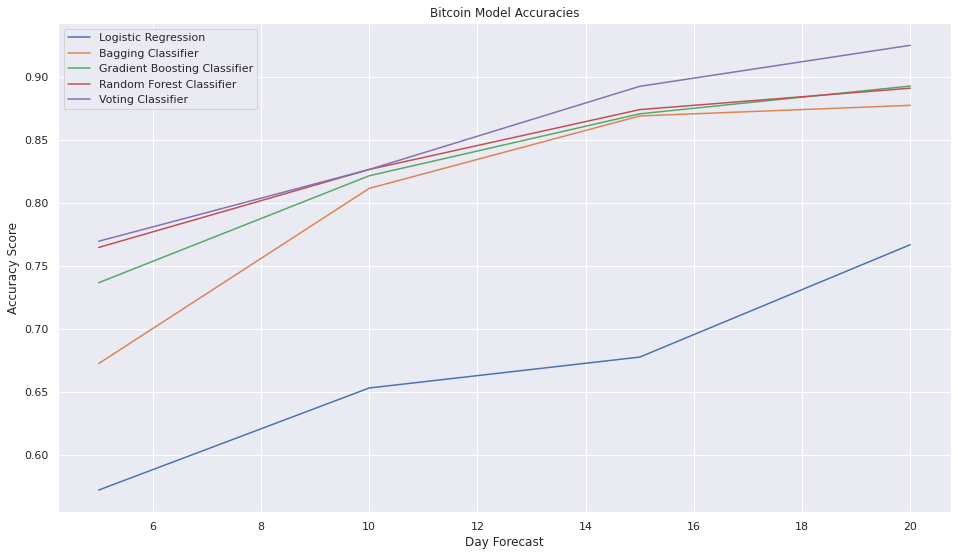

In [79]:
plt.figure(figsize = (16,9))
sn.set(style='darkgrid',)
plt.title("Bitcoin Model Accuracies")
plt.xlabel("Day Forecast")
plt.ylabel("Accuracy Score")
ax = sn.lineplot(x='Day Forecast', y='LogisticRegression', label="Logistic Regression", data=btc_model_accuracies)
ax1 = sn.lineplot(x='Day Forecast', y='BaggingClassifier', label="Bagging Classifier", data=btc_model_accuracies)
ax2 = sn.lineplot(x='Day Forecast', y='GradientBoostingClassifier', label="Gradient Boosting Classifier", data=btc_model_accuracies)
ax3 = sn.lineplot(x='Day Forecast', y='RandomForestClassifier', label = "Random Forest Classifier", data=btc_model_accuracies)
ax3 = sn.lineplot(x='Day Forecast', y='VotingClassifier', label = "Voting Classifier", data=btc_model_accuracies)

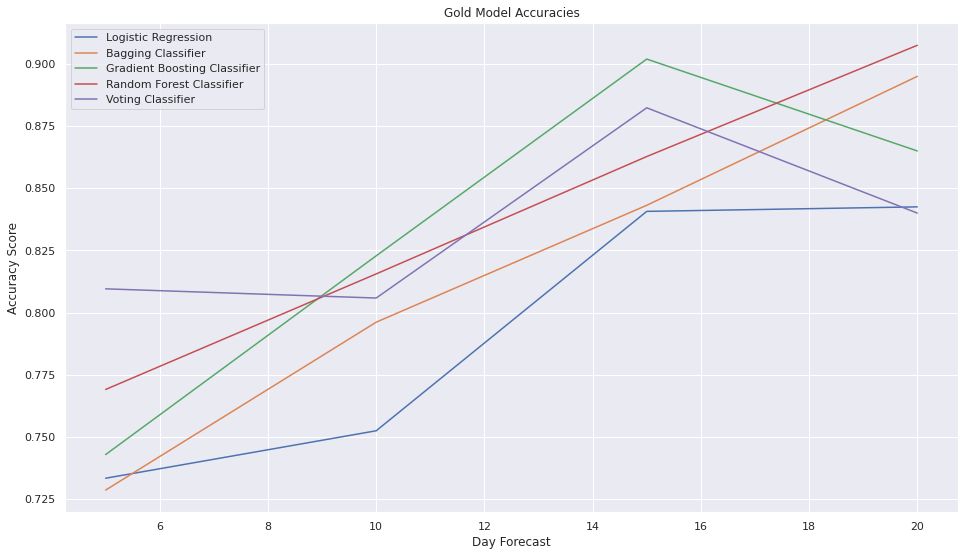

In [80]:
plt.figure(figsize = (16,9))
sn.set(style='darkgrid',)
plt.title("Gold Model Accuracies")
plt.xlabel("Day Forecast")
plt.ylabel("Accuracy Score")
ax = sn.lineplot(x='Day Forecast', y='LogisticRegression', label="Logistic Regression", data=gld_model_accuracies)
ax1 = sn.lineplot(x='Day Forecast', y='BaggingClassifier', label="Bagging Classifier", data=gld_model_accuracies)
ax2 = sn.lineplot(x='Day Forecast', y='GradientBoostingClassifier', label="Gradient Boosting Classifier", data=gld_model_accuracies)
ax3 = sn.lineplot(x='Day Forecast', y='RandomForestClassifier', label = "Random Forest Classifier", data=gld_model_accuracies)
ax3 = sn.lineplot(x='Day Forecast', y='VotingClassifier', label = "Voting Classifier", data=gld_model_accuracies)

In [81]:
X_btc_15 = btc_df_merged_15
Y_btc_15 = classify_btc_15
X_btc_train_15, X_btc_test_15, Y_btc_train_15, Y_btc_test_15 = train_test_split(X_btc_15, Y_btc_15, test_size=0.3)

In [82]:
X_gld_15 = gld_df_merged_15
Y_gld_15 = classify_gld_15
X_gld_train_15, X_gld_test_15, Y_gld_train_15, Y_gld_test_15 = train_test_split(X_gld_15, Y_gld_15, test_size=0.3)

In [83]:
RFR_btc_model = RandomForestClassifier(n_estimators=100)
RFR_btc_model.fit(X_btc_train_15, Y_btc_train_15)

RandomForestClassifier()

In [84]:
RFR_gld_model = RandomForestClassifier(n_estimators=100)
RFR_gld_model.fit(X_gld_train_15, Y_gld_train_15)

RandomForestClassifier()

In [85]:
RFR_btc_model.score(X_btc_test_15, Y_btc_test_15)

0.8993288590604027

In [86]:
RFR_gld_model.score(X_gld_test_15, Y_gld_test_15)

0.8823529411764706

Text(0.5, 0, 'Random Forest Feature Importance')

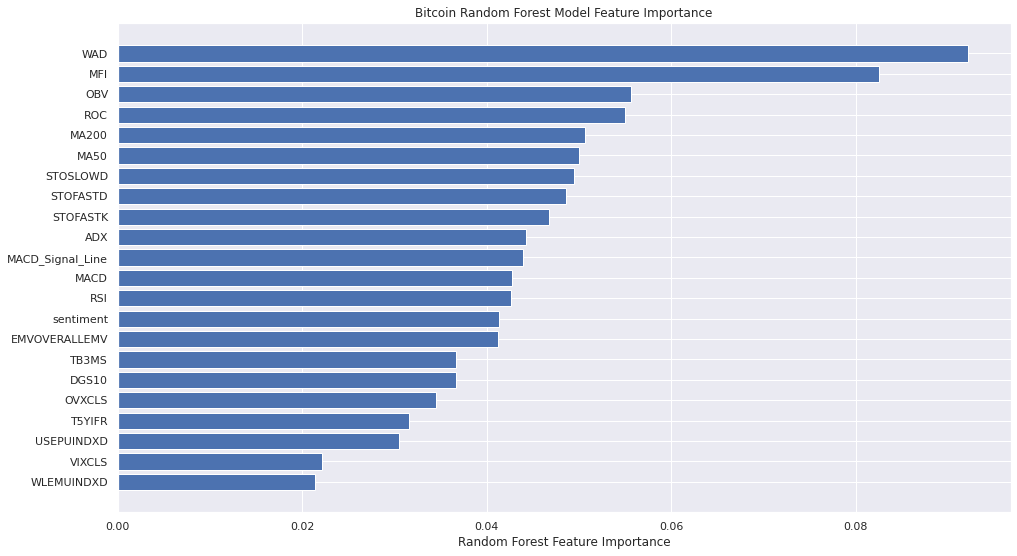

In [87]:
plt.figure(figsize = (16,9))
plt.title("Bitcoin Random Forest Model Feature Importance")
sorted_idx = RFR_btc_model.feature_importances_.argsort()
plt.barh(X_btc_test_15.columns, RFR_btc_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

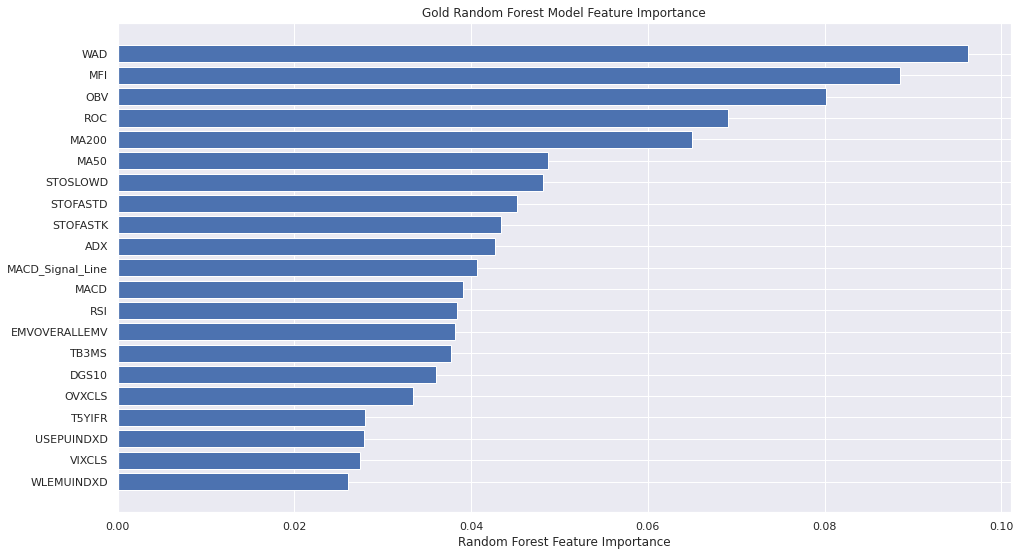

In [88]:
plt.figure(figsize = (16,9))
plt.title("Gold Random Forest Model Feature Importance")
sorted_idx = RFR_gld_model.feature_importances_.argsort()
plt.barh(X_gld_test_15.columns, RFR_gld_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [89]:
y_pred = RFR_btc_model.predict(X_btc_test_15)
cf_matrix = confusion_matrix(Y_btc_test_15, y_pred)
print(cf_matrix)

[[82  8]
 [ 7 52]]


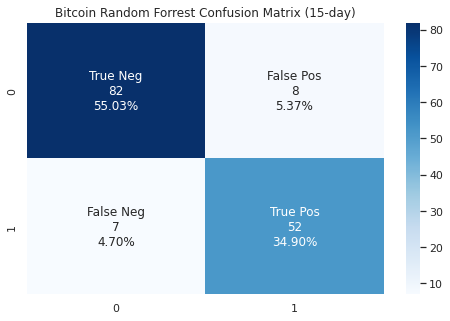

In [90]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title("Bitcoin Random Forrest Confusion Matrix (15-day)")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [91]:
cm_metrics(cf_matrix)

Accuracy: 0.9
Mis-Classification: 0.1
Sensitivity: 0.88
Specificity: 0.91
Precision: 0.91
f_1 Score: 0.9


In [92]:
y_pred = RFR_gld_model.predict(X_gld_test_15)
cf_matrix = confusion_matrix(Y_gld_test_15, y_pred)
print(cf_matrix)

[[34  7]
 [ 5 56]]


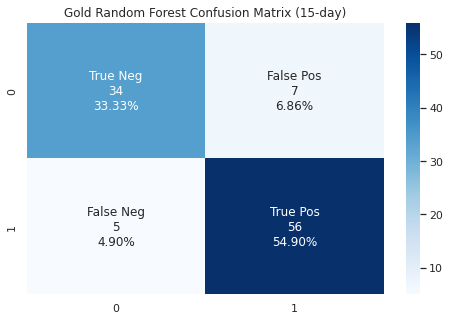

In [93]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title("Gold Random Forest Confusion Matrix (15-day)")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [94]:
cm_metrics(cf_matrix)

Accuracy: 0.88
Mis-Classification: 0.12
Sensitivity: 0.92
Specificity: 0.83
Precision: 0.83
f_1 Score: 0.87


In [95]:
X_btc_train_5.columns

Index(['WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS', 'DGS10',
       'TB3MS', 'EMVOVERALLEMV', 'sentiment', 'RSI', 'MACD',
       'MACD_Signal_Line', 'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50',
       'MA200', 'ROC', 'OBV', 'MFI', 'WAD'],
      dtype='object')